In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)
library(modelr)
library(preprocessCore)
devtools::load_all('/home/jpm73279/software/preprocessCore')
library("edgeR")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.1”

Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.2     
Warning message:
“package ‘ggplot2’ was built under 

In [2]:
zm_working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays"


#gene_bodysorghum_bicolor_tis_leaf_nmf_step_2_knn_27.out.de_novo.rds
zm_input <- here(zm_working_dir,"00.data/zea_mays.gene_body_acc_leaf_V3_clustering_strict.counts.tab.txt")
#input_2 <- here("/home/jpm73279/r_script_dev/lw_plotting","zea_mays.normalized_gene_acc_scores.leaf_svd_knn_100_strict.GBaccessibility.sparse")
zm_meta <- here(zm_working_dir,"00.data/Zm_leaf.V3_final.txt")
zm_gene <- here(zm_working_dir,"00.data/Zm.markers.leaf.txt")
zm_gene_DA <- here(zm_working_dir,"00.data/Zm-B73-REFERENCE-NAM_Zm00001eb.1.genes.bed")
#prefix <- "TEST_SORGHUM_TEST"

zm_meta_data <- read.delim(zm_meta)
zm_gene_markers <- read.delim(zm_gene)
zm_gene_markers <- zm_gene_markers  %>%
    arrange(type)

zm_all_markers <- zm_gene_markers$geneID

zm_raw_cpm_counts_all_genes <- read_delim(zm_input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

zm_merged_meta_cpm_information <- left_join(zm_meta_data, zm_raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(V3_final_annnotation, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
zm_merged_meta_cpm_information_copied <- zm_merged_meta_cpm_information
zm_catch <- zm_merged_meta_cpm_information_copied  %>%
    group_by(V3_final_annnotation) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



zm_caught_values <- as_tibble(zm_catch)
zm_see <- ungroup(zm_merged_meta_cpm_information_copied)
zm_merged_meta_cpm_information_copied<- bind_cols(zm_merged_meta_cpm_information_copied,zm_caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    mutate(species = "Zm")  %>% 
    group_by(V3_final_annnotation) %>%  
    mutate(log_cpm  = log(grouped_CPM))


#Apply quantile normalization
zm_merged_meta.quant_norm <- zm_merged_meta_cpm_information_copied  %>% 
        group_by(V3_final_annnotation)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

zm.quantile_normalized <- as_tibble(zm_merged_meta.quant_norm)  %>% 
    rename("quant_norm_cpm" = value)


zm_merged_meta_cpm_information_copied <- bind_cols(zm_merged_meta_cpm_information_copied, zm.quantile_normalized)


Rows: 22169188 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'V3_final_annnotation'. You can override using the `.groups` argument.


In [3]:

sb_working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/sorghum_bicolor"


sb_input <- here(sb_working_dir,"00.data/sb.gene_accessability.iter_1.scores.txt")
sb_meta <- here("/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/sb_annot_v4/Sb.leaf_annot.V4.meta.final.2022-10-10.txt")

sb_gene <- here(sb_working_dir,"00.data/Sb.orthos_from.zm.markers.de_novo.all.leaf.visualize.txt")
sb_gene_DA <- here(sb_working_dir,"00.data/Sbicolorv5.1.gene.bed")
#prefix <- "TEST_SORGHUM_TEST"

sb_meta_data <- read.delim(sb_meta)
sb_gene_markers <- read.delim(sb_gene)
sb_gene_markers <- sb_gene_markers  %>%
    arrange(type)



all_markers <- sb_gene_markers$geneID
sb_raw_cpm_counts_all_genes <- read_delim(sb_input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)


sb_merged_meta_cpm_information <- left_join(sb_meta_data, sb_raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(sb_v4_annot, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
sb_merged_meta_cpm_information_copied <- sb_merged_meta_cpm_information
sb_catch <- sb_merged_meta_cpm_information_copied  %>%
    group_by(sb_v4_annot) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()


sb_caught_values <- as_tibble(sb_catch)
sb_see <- ungroup(sb_merged_meta_cpm_information_copied)
sb_merged_meta_cpm_information_copied <- bind_cols(sb_merged_meta_cpm_information_copied,sb_caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    mutate(species = "Sb")  %>% 
    group_by(sb_v4_annot) %>%  
    mutate(log_cpm  = log(grouped_CPM))

#Apply quantile normalization
sb_merged_meta.quant_norm <- sb_merged_meta_cpm_information_copied  %>% 
        group_by(sb_v4_annot)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

sb.quantile_normalized <- as_tibble(sb_merged_meta.quant_norm)  %>% 
    rename("quant_norm_cpm" = value)

#Combine and re_name
sb_merged_meta_cpm_information_copied <- bind_cols(sb_merged_meta_cpm_information_copied, sb.quantile_normalized)



Rows: 35644015 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'sb_v4_annot'. You can override using the `.groups` argument.


In [4]:
sb.cell_type_accessability <- sb_merged_meta_cpm_information_copied  %>% 
    ungroup()  %>% 
    mutate(species_cell_type = str_c(species, sb_v4_annot, sep = "."))  %>% 
    select(species_cell_type, geneID, quant_norm_cpm)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cpm, values_fill = 0)


zm.cell_type_accessability <- zm_merged_meta_cpm_information_copied  %>% 
    ungroup()  %>% 
    mutate(species_cell_type = str_c(species, V3_final_annnotation, sep = "."))  %>% 
    select(species_cell_type, geneID, quant_norm_cpm)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cpm, values_fill = 0)
    

In [5]:
Sb.Zm.key_file <- read_delim("/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/markers/Sb.orthos_from.Zm.key_file.txt", 
                             col_names = c("sb", "zm", "gene_name", "cell_type", "tis"))  %>% 
        distinct()

Rows: 260 Columns: 5
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): sb, zm, gene_name, cell_type, tis

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
head(zm.cell_type_accessability)

geneID,Zm.bundle_sheath,Zm.companion_cells,Zm.developing_mesophyll,Zm.epidermal,Zm.guard_cell,Zm.mesophyll,Zm.metaphloem_sieve_element,Zm.procambium,Zm.protoderm,Zm.subsidary_cell,Zm.unknown,Zm.vascular_parenchyma,Zm.xylem
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zm00001eb000010,11.2028624,9.771907,16.417901,4.3099576,3.587238,8.4063417,4.948156,0.000000,11.0319264,0.00000,5.308367,8.618003,0.000000
Zm00001eb000020,2.6278319,9.771907,8.208951,3.3153520,10.761714,2.7263811,9.896311,2.546541,10.7254840,15.78432,4.423640,15.320894,13.421723
Zm00001eb000050,0.5532278,0.000000,0.000000,0.1657676,0.000000,0.2271984,4.948156,0.000000,0.6128848,15.78432,0.000000,0.000000,4.473908
Zm00001eb000060,18.8097443,27.687071,22.574614,26.6885834,21.523428,19.7662628,34.637090,45.837742,22.0638528,39.46081,23.887654,31.120565,17.895630
Zm00001eb000070,10.2347138,13.843535,0.000000,10.1118235,21.523428,7.1567503,9.896311,25.465412,12.2576960,0.00000,24.772382,7.660447,31.317353
Zm00001eb000080,41.2154691,57.002793,25.652971,47.0779980,46.634095,43.7356964,56.903791,12.732706,47.4985720,63.13729,33.619661,55.538240,13.421723


In [7]:
### 7/23/2022 List of maarkers
good_marker_list <- c('pepc1', "cah1", "ssu1", "ssu2", "agp2", "me3", "sut1", "fama_v4v5count_1", 
                      "dct2", "shr2h", "shr2", "gl1", "ZmAAP6_4", "bhlh43","ocl1",
                     "shr1_v4v5count_1", "sut7", 'sweet13a','sweet13b','sweet13c','sweet1b', 
                      "cvp2", "fdl", "cvl2", "ad1", "fcp1", "ids1", "KCS1", 
                      "mdh6", "vt2","ZmAPL", "ZmSWEET11", "zyb14", "ocl5", "ocl4", "hkt1_2", "kch1",
                      "slac_v4v5count_1", "bhlh43", "dct2", "KCS1", "scr1", "ZmLAX2", "acl5", "pdf1", 
                      "xcp1", "gpat12", "pdf1", "pdf2","snd1",
                      "pdf2", "ZmLRD3", "ad1", "ZmSMXL4_v4v5count_1", "SID1", "ZmSMXL5")

good_gene_markers <- Sb.Zm.key_file  %>% 
    filter(gene_name %in% good_marker_list)  %>% 
    select(-cell_type, -tis)



In [8]:
final_combined_dataset <- left_join(good_gene_markers, zm.cell_type_accessability, by = c("zm" = "geneID"))  %>% 
    left_join(., sb.cell_type_accessability, by = c("sb" = "geneID"))  %>% 
    rowwise()  %>% 
    mutate(unique_count = n())

generate_corr_matrix <- final_combined_dataset  %>% 
    select(-sb, -zm, -gene_name, -unique_count)

cell_type_corr_matrix <- cor(generate_corr_matrix)

In [9]:
head(cell_type_corr_matrix)

,Zm.bundle_sheath,Zm.companion_cells,Zm.developing_mesophyll,Zm.epidermal,Zm.guard_cell,Zm.mesophyll,Zm.metaphloem_sieve_element,Zm.procambium,Zm.protoderm,Zm.subsidary_cell,⋯,Sb.developing_mesophyll,Sb.epidermis,Sb.ground_meristem,Sb.mesophyll,Sb.phloem,Sb.procambium,Sb.proto_xylem,Sb.protoderm,Sb.unknown.7,Sb.xylem
Zm.bundle_sheath,1.0000000,0.3292604,0.2182733,0.3552076,0.4920094,0.2007808,0.4907993,-0.01000845,0.3627732,0.1740050,⋯,0.2176334,0.1958184,0.2301001,0.1846091,0.2743516,0.4279969,0.2456799,0.1847133,0.3648240,0.2534424
Zm.companion_cells,0.3292604,1.0000000,0.3812350,0.3464764,0.5310274,0.3492290,0.8456658,0.17089229,0.3773769,0.1989637,⋯,0.3310172,0.2028363,0.2442325,0.2932010,0.4613930,0.3350462,0.4229674,0.2284212,0.6725738,0.3590292
Zm.developing_mesophyll,0.2182733,0.3812350,1.0000000,0.4376367,0.5014823,0.9629308,0.7154597,0.18531157,0.5302721,0.5456004,⋯,0.8931463,0.4090610,0.4774286,0.9063443,0.2615724,0.3560446,0.5249550,0.4650191,0.4173177,0.6482836
Zm.epidermal,0.3552076,0.3464764,0.4376367,1.0000000,0.9556144,0.4085755,0.4403250,0.40098885,0.9590089,0.6580736,⋯,0.4630205,0.8848717,0.8507461,0.4345550,0.2230201,0.2849039,0.5617279,0.8236303,0.3554879,0.8055690
Zm.guard_cell,0.4920094,0.5310274,0.5014823,0.9556144,1.0000000,0.4703620,0.6225188,0.42004668,0.9210291,0.6114816,⋯,0.5123799,0.8135637,0.7993468,0.4775380,0.3419554,0.3635801,0.6032166,0.7714893,0.4990715,0.7905669
Zm.mesophyll,0.2007808,0.3492290,0.9629308,0.4085755,0.4703620,1.0000000,0.6949037,0.17728882,0.4732175,0.5171282,⋯,0.8799909,0.4280814,0.4784267,0.8956944,0.2369404,0.3255361,0.5412441,0.4901066,0.4324053,0.6598918


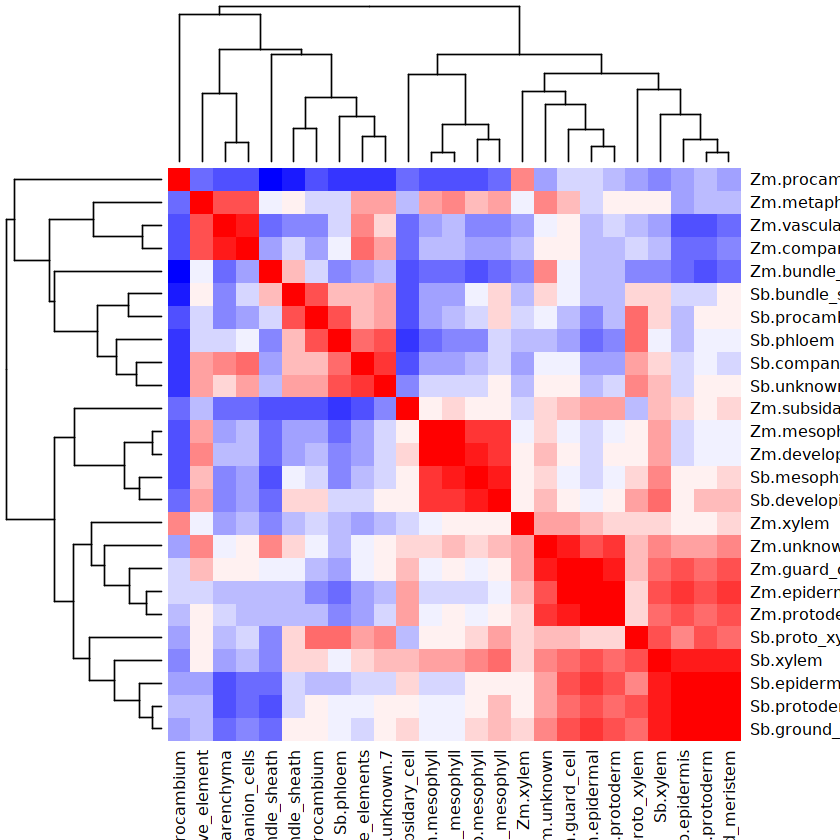

In [10]:
col<- colorRampPalette(c("blue", "white", "red"))(20)
heatmap(x = cell_type_corr_matrix, col = col, symm = TRUE)

corrplot 0.92 loaded



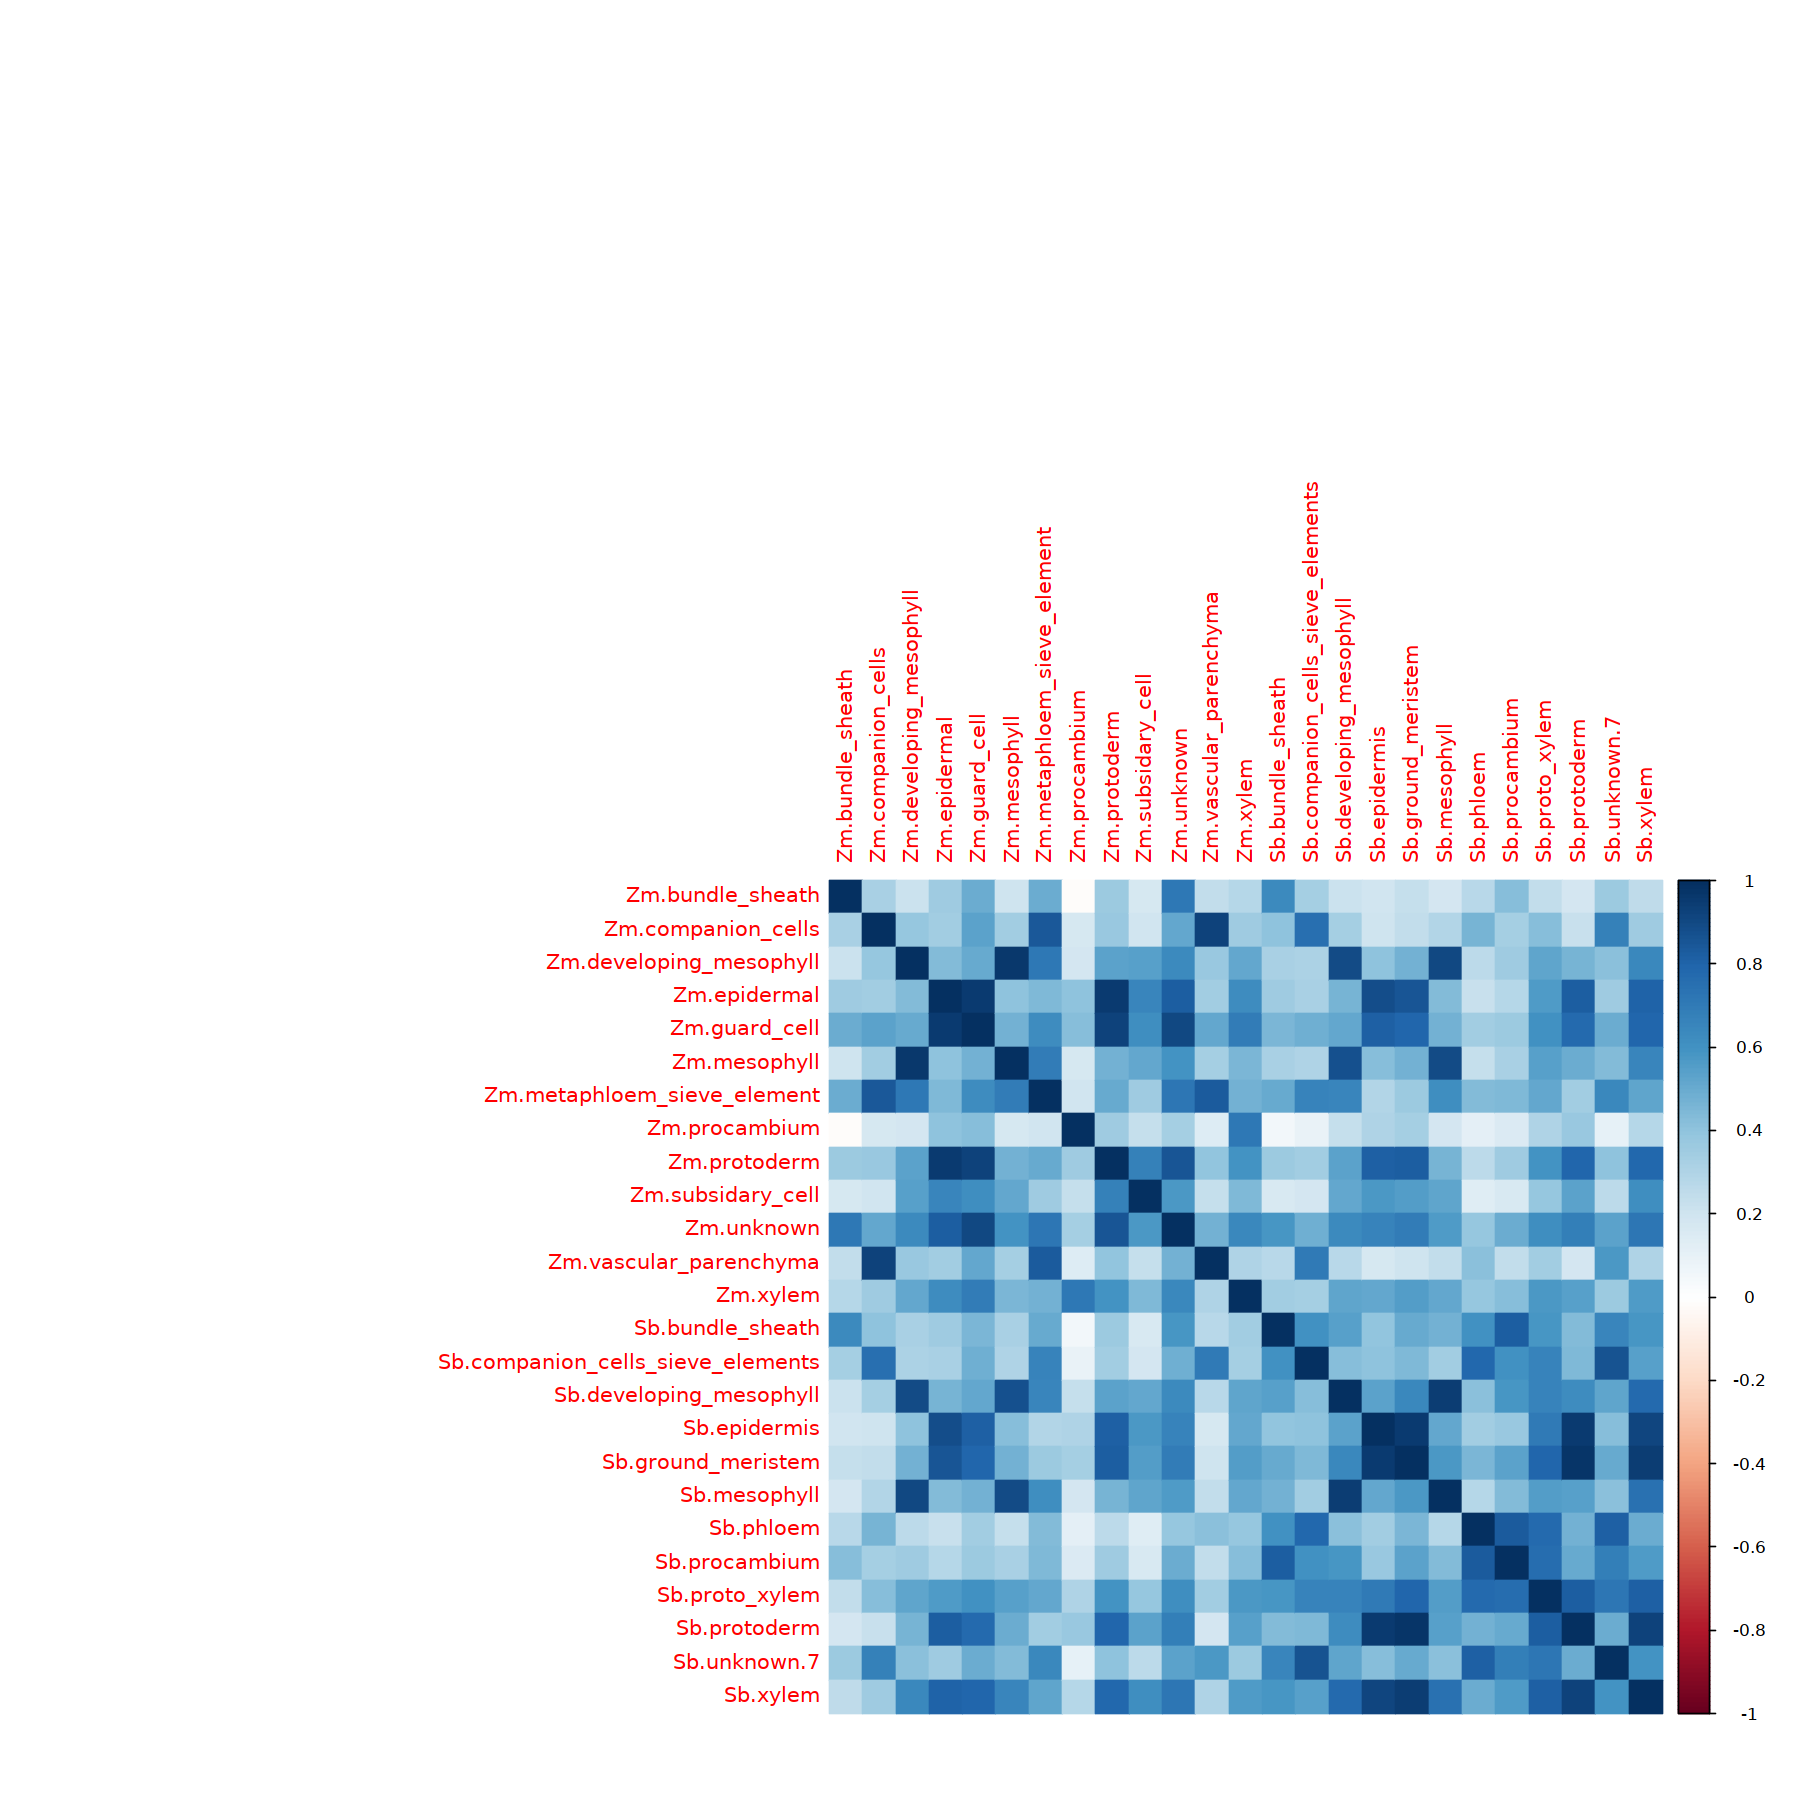

In [11]:
library(corrplot)
options(repr.plot.width=15, repr.plot.height=15)
corrplot(cell_type_corr_matrix, method="color")

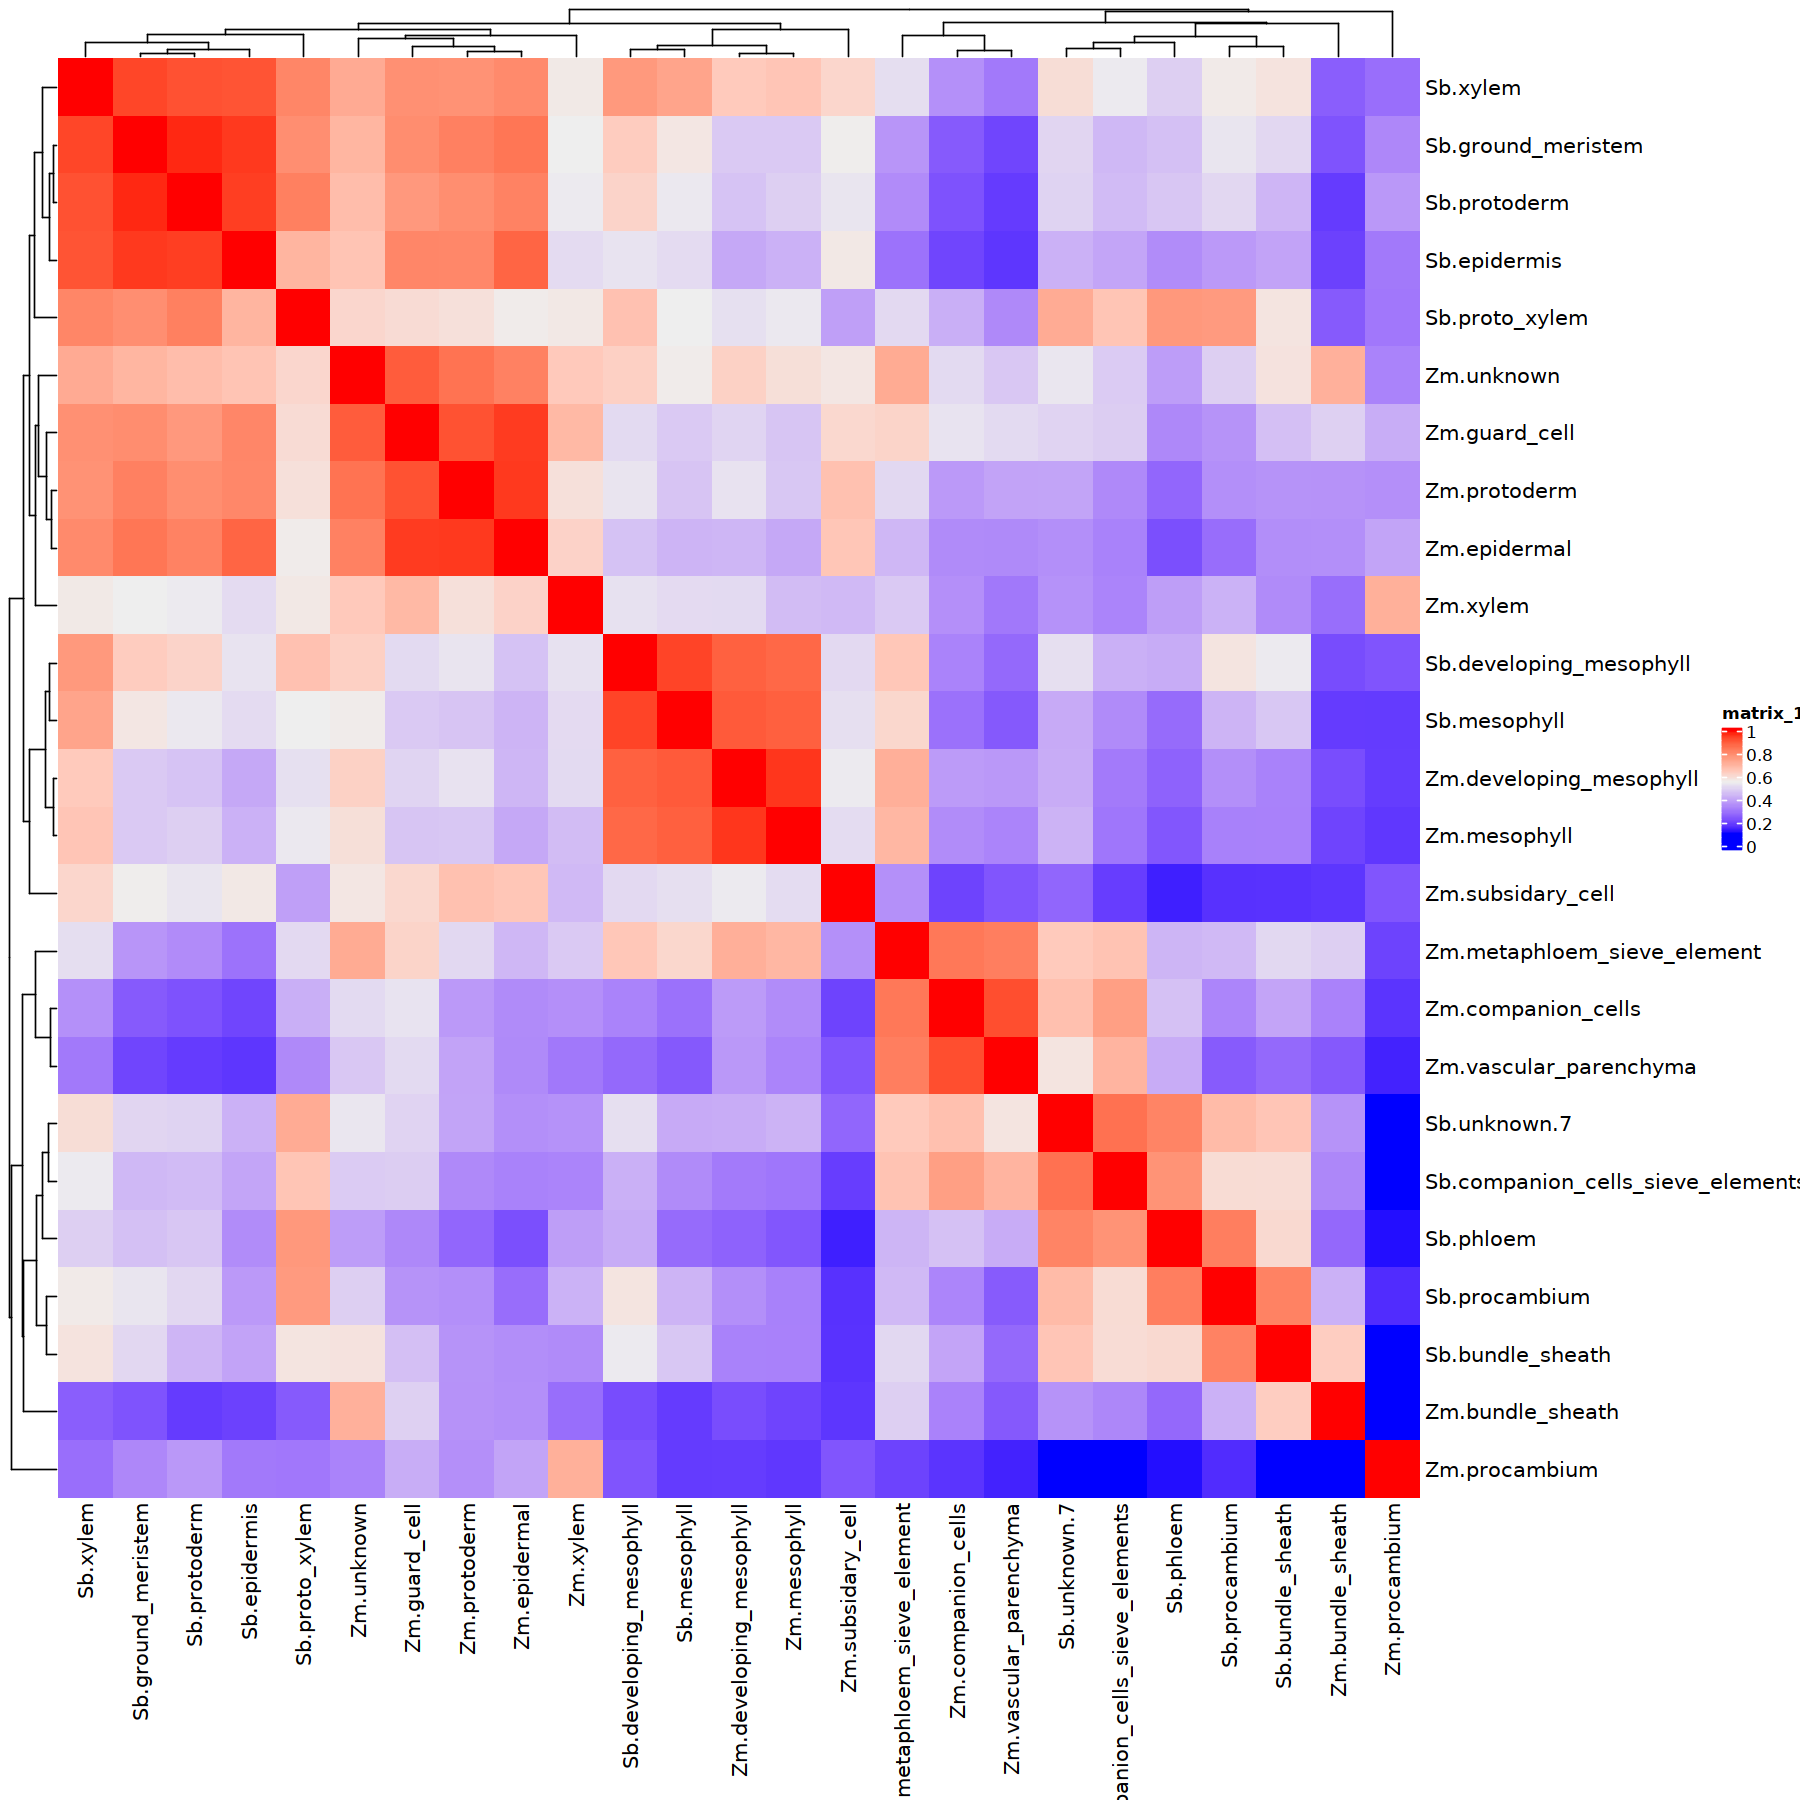

In [12]:
library(ComplexHeatmap)
Heatmap(cell_type_corr_matrix)

In [13]:
zm.cell_types <- left_join(good_gene_markers, zm.cell_type_accessability, by = c("zm" = "geneID"))  %>% 
    select(-sb, -zm, -gene_name)
sb.cell_types <- left_join(good_gene_markers, sb.cell_type_accessability, by = c("sb" = "geneID"))  %>% 
    select(-sb, -zm, -gene_name)



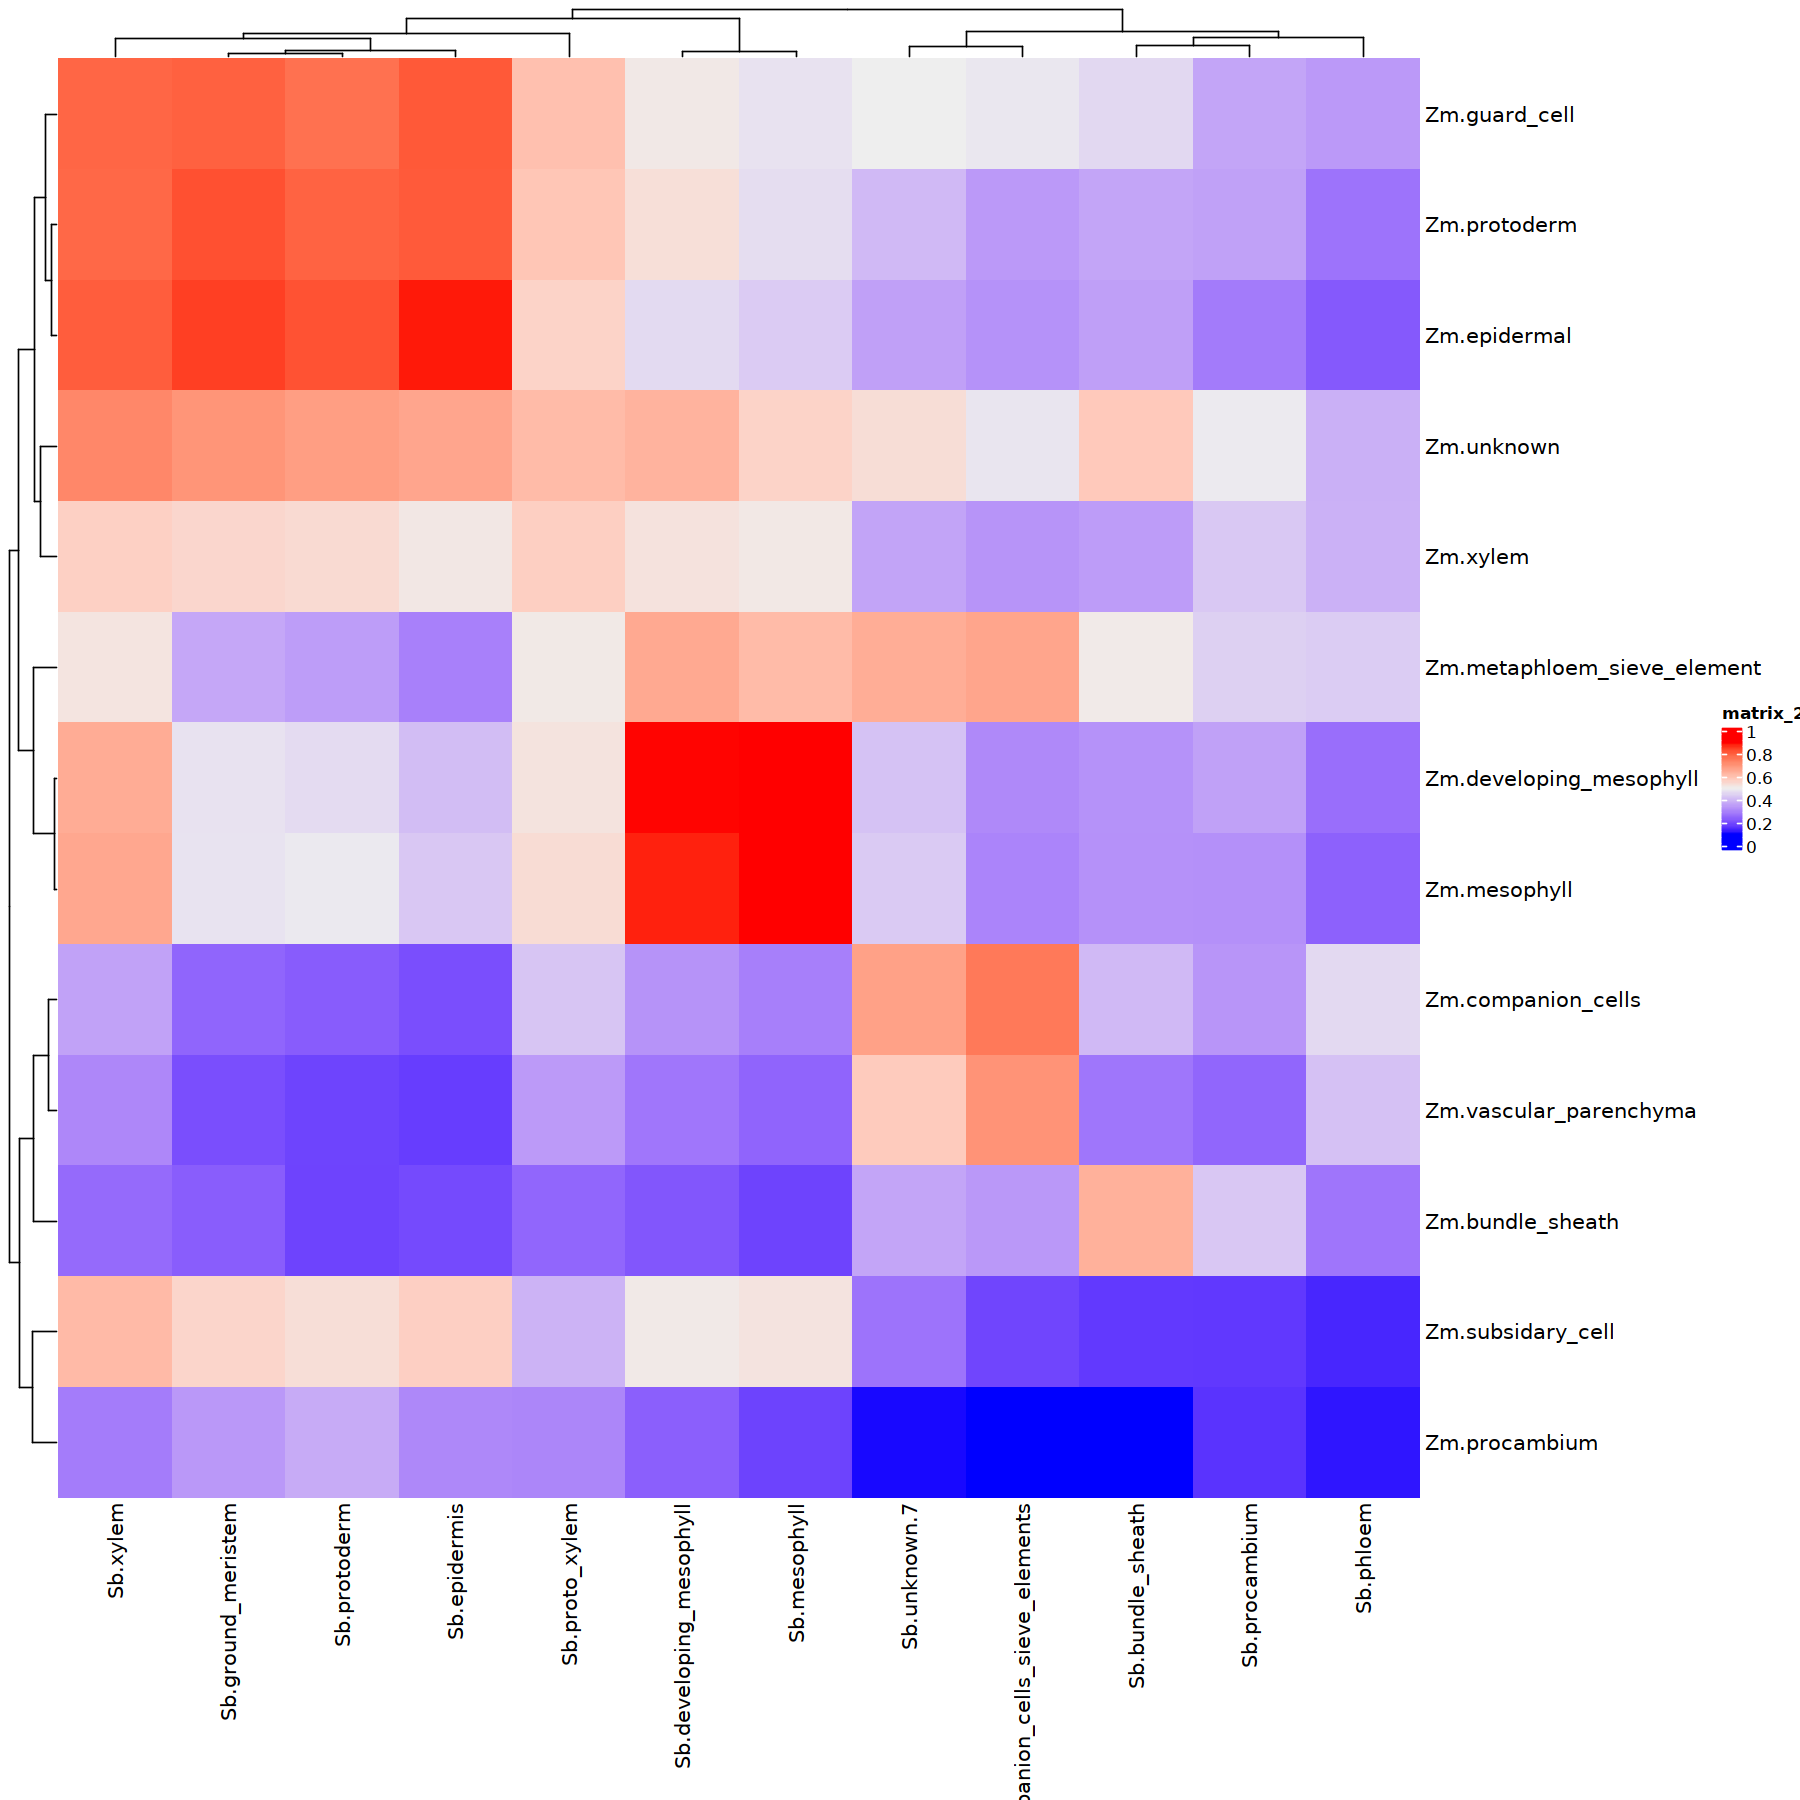

In [14]:
sep_corr_matrix <- cor(zm.cell_types, sb.cell_types)
Heatmap(sep_corr_matrix)

In [15]:
## Working now on Single Copy Ortholouges

zm_base <- "Zm"
sb_base <- "Sobic"

Sb_vs_Zm_orthos <- read_delim("/scratch/jpm73279/13.ACR_CNS_analysis/01.analysis/run_orthofinder/2022-06-21_plant_genomes_grass_lineages/OrthoFinder/Results_Jun22/Orthologues/Orthologues_Sbicolor.prot/Sbicolor.prot__v__Zm-B73.prot.tsv") 

#Gross output here that needs to be fixed from orthofinder.
colnames(Sb_vs_Zm_orthos) <- sub("-", "_", colnames(Sb_vs_Zm_orthos), fixed = TRUE)

Rows: 20081 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Orthogroup, Sbicolor.prot, Zm-B73.prot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [16]:
Sb_vs_Zm_orthos.fixed <- Sb_vs_Zm_orthos  %>% 
    rowwise() %>% 
    mutate(Sb_count = str_count(Sbicolor.prot, pattern = ","))  %>% 
    mutate(Zm_count = str_count(Zm_B73.prot, pattern = ",")) %>%
    dplyr::filter(Sb_count == 0 & Zm_count == 0) %>% 
    mutate(zm_gene = str_replace(Zm_B73.prot, "_P00.*", "")) %>%
    mutate(sb_gene = str_replace(Sbicolor.prot, "\\.[^\\.]*$", ""))
    


In [17]:
sb.zm.single_copy <- Sb_vs_Zm_orthos.fixed  %>% 
    select(Orthogroup, zm_gene, sb_gene)

In [18]:
sb.cell_types.all_orthos <- left_join(sb.zm.single_copy, sb.cell_type_accessability, by = c("sb_gene" = "geneID")) %>% 
    drop_na()


zm.cell_types.all_orthos <- left_join(sb.zm.single_copy, zm.cell_type_accessability, by = c("zm_gene" = "geneID")) %>% 
    dplyr::filter(sb_gene %in% sb.cell_types.all_orthos$sb_gene)


In [19]:
sb.cell_types.all_orthos.final <- sb.cell_types.all_orthos  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.all_orthos.final <- zm.cell_types.all_orthos  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

In [20]:
dim(zm.cell_types.all_orthos.final)
dim(sb.cell_types.all_orthos.final)

[1] 9349   13

[1] 9349   12

In [21]:
head(sb.cell_types.all_orthos.final)

Sb.bundle_sheath,Sb.companion_cells_sieve_elements,Sb.developing_mesophyll,Sb.epidermis,Sb.ground_meristem,Sb.mesophyll,Sb.phloem,Sb.procambium,Sb.proto_xylem,Sb.protoderm,Sb.unknown.7,Sb.xylem
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12.600860,9.406383,56.239484,1.996629,8.456038,18.4067212,18.014311,64.816812,30.053183,38.804180,0.000000,7.30882
18.079495,3.359423,6.461558,13.477243,33.119482,7.3800533,7.584973,22.296983,13.292754,24.958999,7.519325,31.51928
11.368167,14.109575,15.076968,14.752867,24.428554,5.7303943,24.651162,15.037500,34.676749,37.485591,15.038649,10.96323
1.369659,1.343769,1.914536,7.598281,2.348899,0.5209449,5.688730,4.666810,2.311783,1.977883,10.025766,10.96323
52.183996,35.609880,102.188338,139.153920,126.370788,139.3527711,7.584973,9.852155,19.072212,25.995033,77.699688,88.16264
2.739317,4.031307,10.051312,7.653743,44.159309,7.7273499,5.688730,3.111207,13.870700,43.136685,7.519325,27.40807


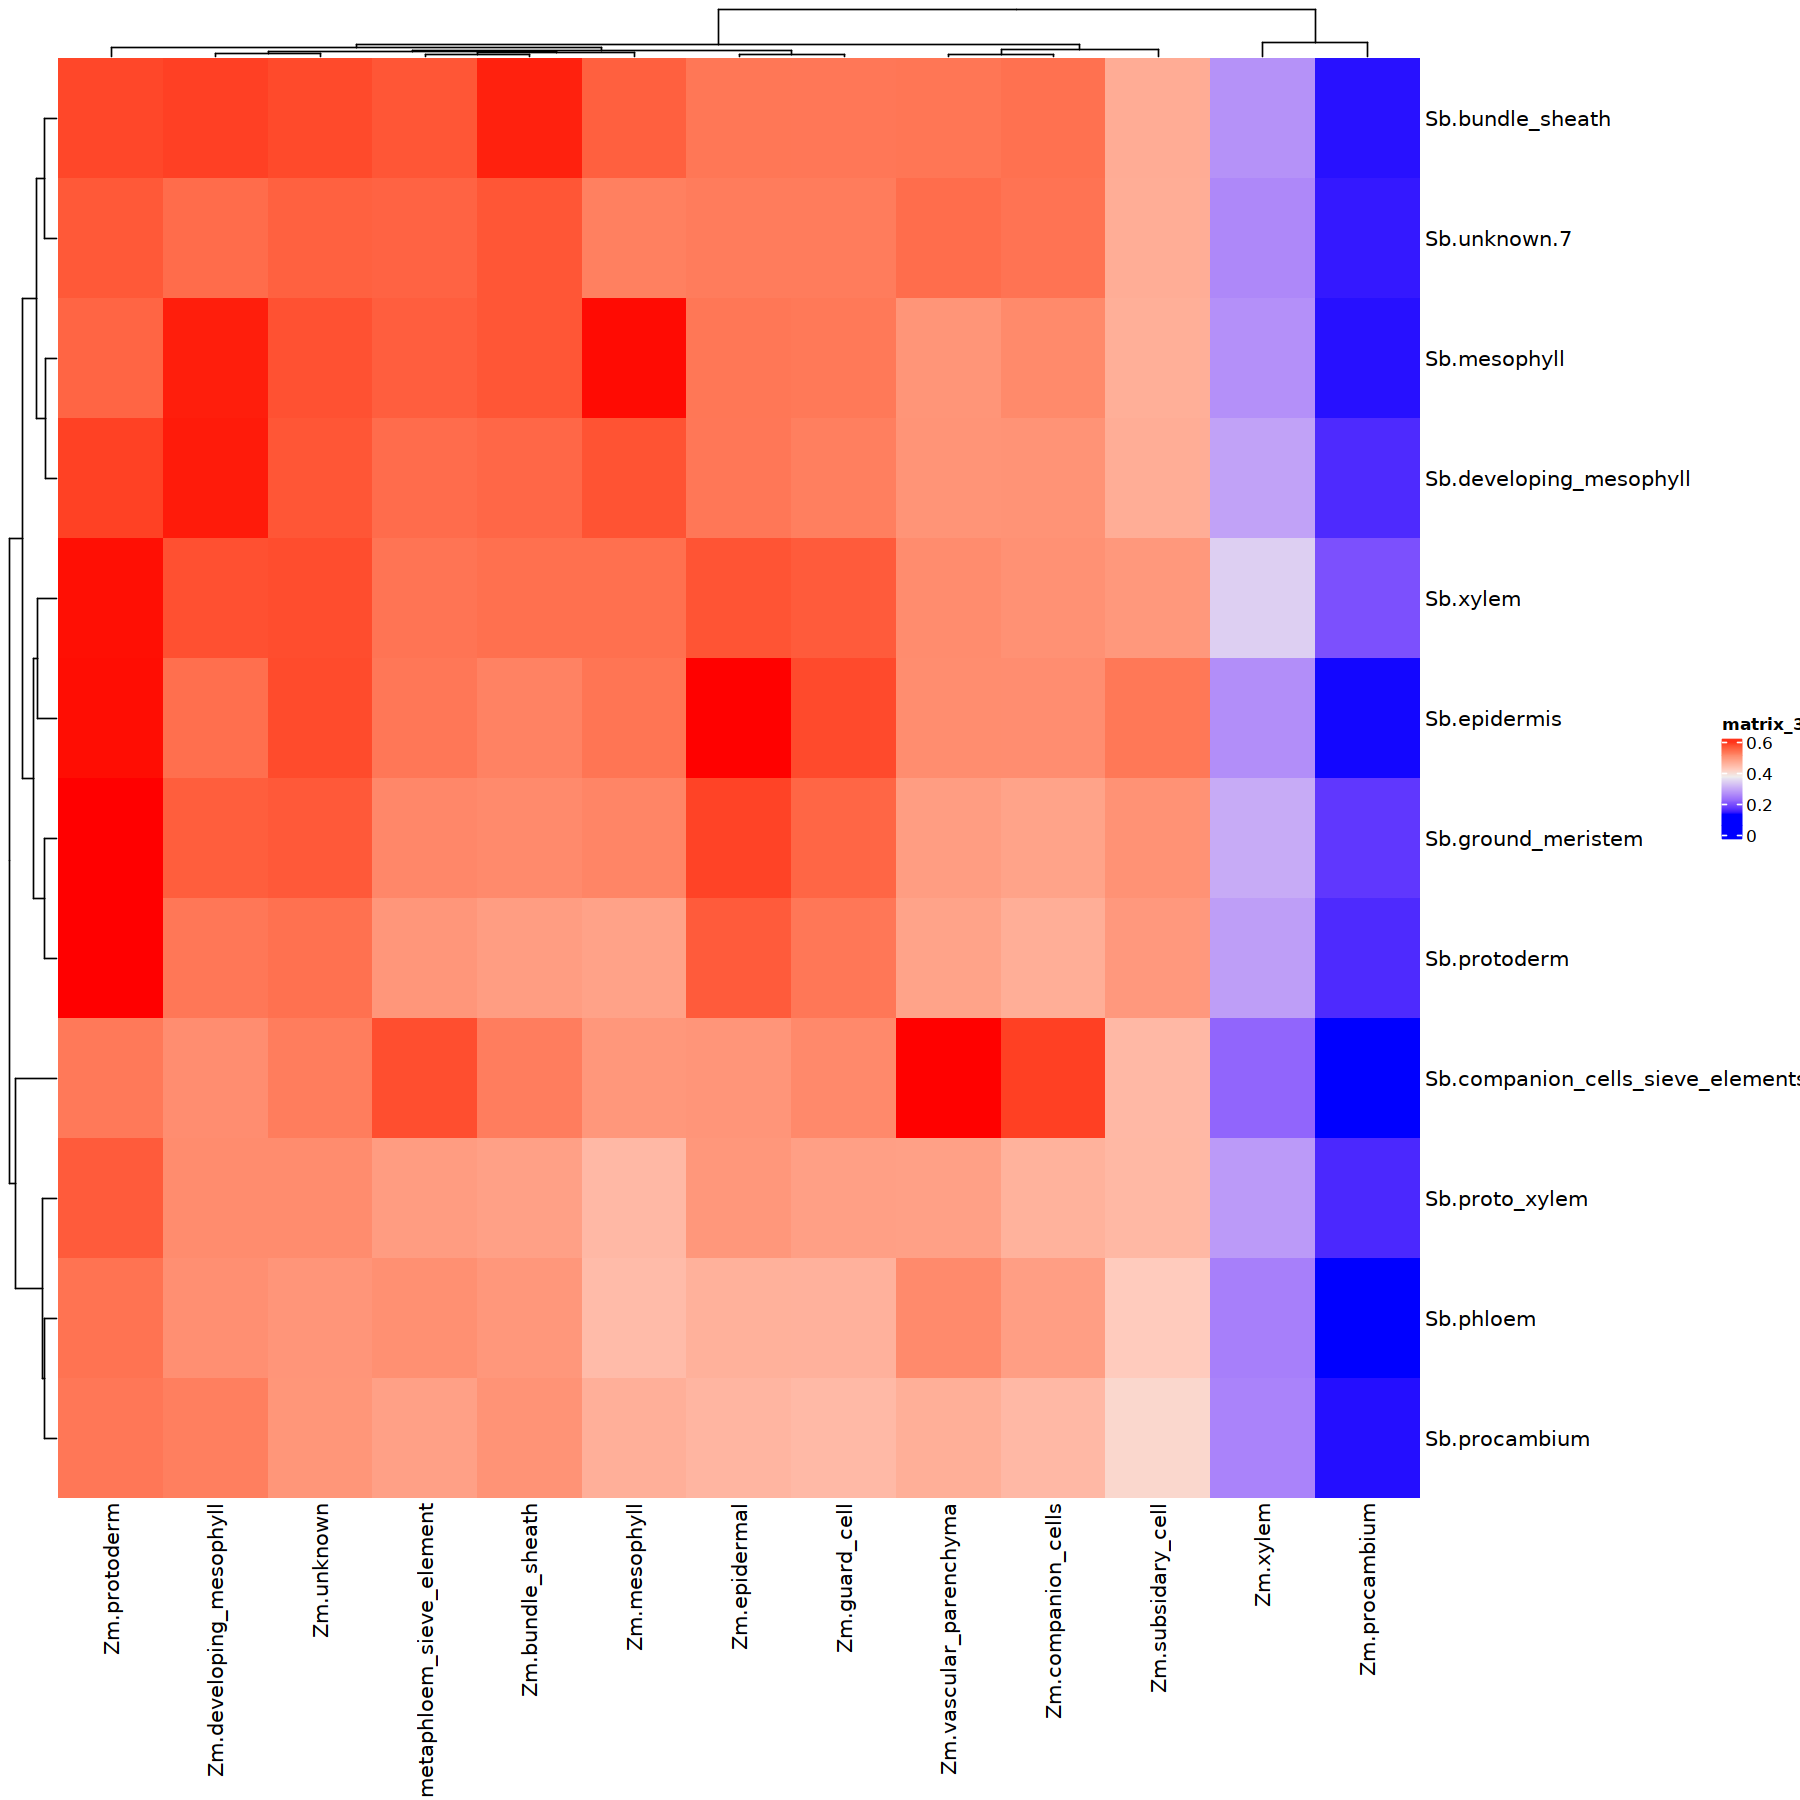

In [22]:
all_orthos_corr <- cor((sb.cell_types.all_orthos.final), (zm.cell_types.all_orthos.final))
Heatmap(all_orthos_corr)

# Selecting the 1000-2000 most variable single copy orthos

In [23]:
combined_sb_zm <- full_join(sb.cell_types.all_orthos, zm.cell_types.all_orthos)

combined_sb_zm.subset <- combined_sb_zm  %>% 
    #dplyr::select(-zm_gene, -sb_gene) %>% 
    #mutate(row_n = row_number()) %>%
    mutate(ortho_unique = str_c(Orthogroup, zm_gene, sb_gene, sep = "__"))  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)

Joining, by = c("Orthogroup", "zm_gene", "sb_gene")


In [24]:
combined_sb_zm.subset.mean.var <- combined_sb_zm.subset %>%
    pivot_longer(!ortho_unique, names_to = "cell_type", values_to = "score")  %>% 
    group_by(ortho_unique)  %>% 
      summarize(mean = mean(score),
            var = var(score))

regression <- loess(var ~ mean, data=combined_sb_zm.subset.mean.var)

combined_sb_zm.subset.mean.var.final <- combined_sb_zm.subset.mean.var %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  %>% 
    top_n(300)

In [26]:
head(combined_sb_zm.subset.mean.var.final)

ortho_unique,mean,var,resid
<chr>,<dbl>,<dbl>,<dbl>
OG0018627__Zm00001eb047030__Sobic.001G234000,38.47396,2217.387,1543.669
OG0014816__Zm00001eb169570__Sobic.005G115600,51.19084,2545.491,1545.087
OG0013823__Zm00001eb295960__Sobic.009G233500,27.39134,1977.893,1551.401
OG0015240__Zm00001eb409750__Sobic.008G100300,46.46041,2424.991,1553.154
OG0011280__Zm00001eb024960__Sobic.001G284600,79.87282,3486.797,1562.250
OG0003092__Zm00001eb316070__Sobic.002G237900,38.43197,2240.507,1567.788


In [27]:
combined_sb_zm.subset.mean.var.final.split <- combined_sb_zm.subset.mean.var.final  %>% 
    separate(ortho_unique, into = c("Orthogroup", "zm_gene", "sb_gene"), sep = "__")  %>% 
    dplyr::select(Orthogroup, zm_gene, sb_gene)

In [28]:
sb.cell_types.var_orthos.final <- left_join(combined_sb_zm.subset.mean.var.final.split, sb.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.var_orthos.final <- left_join(combined_sb_zm.subset.mean.var.final.split,zm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

Joining, by = c("Orthogroup", "zm_gene", "sb_gene")
Joining, by = c("Orthogroup", "zm_gene", "sb_gene")


In [29]:
dim(sb.cell_types.var_orthos.final)
dim(zm.cell_types.var_orthos.final)

[1] 300  12

[1] 300  13

In [30]:
head(zm.cell_types.var_orthos.final)

Zm.bundle_sheath,Zm.companion_cells,Zm.developing_mesophyll,Zm.epidermal,Zm.guard_cell,Zm.mesophyll,Zm.metaphloem_sieve_element,Zm.procambium,Zm.protoderm,Zm.subsidary_cell,Zm.unknown,Zm.vascular_parenchyma,Zm.xylem
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
90.17613,64.33172,50.27982,66.14127,64.570285,59.52599,66.80010,24.19214,72.93329,197.30404,72.54769,90.967806,20.13258
56.70585,73.28931,92.35069,69.45662,84.300094,70.31791,49.48156,230.46198,81.51368,78.92162,83.16442,80.434692,93.95206
14.66054,18.72949,62.59325,8.28838,5.380857,11.47352,14.84447,226.64217,30.03136,0.00000,23.00293,10.533114,42.50212
149.37150,48.85954,110.82083,68.46202,43.046857,121.89195,128.65205,50.93082,65.88512,47.35297,133.59392,85.222471,51.44994
81.18618,298.85750,63.61937,83.38110,96.855427,91.44737,86.59272,17.82579,53.32098,220.98052,91.12698,66.071354,67.10861
27.10816,33.38735,93.37681,15.91369,50.221333,220.83687,59.37787,113.32108,26.04760,0.00000,59.27677,7.660447,46.97603


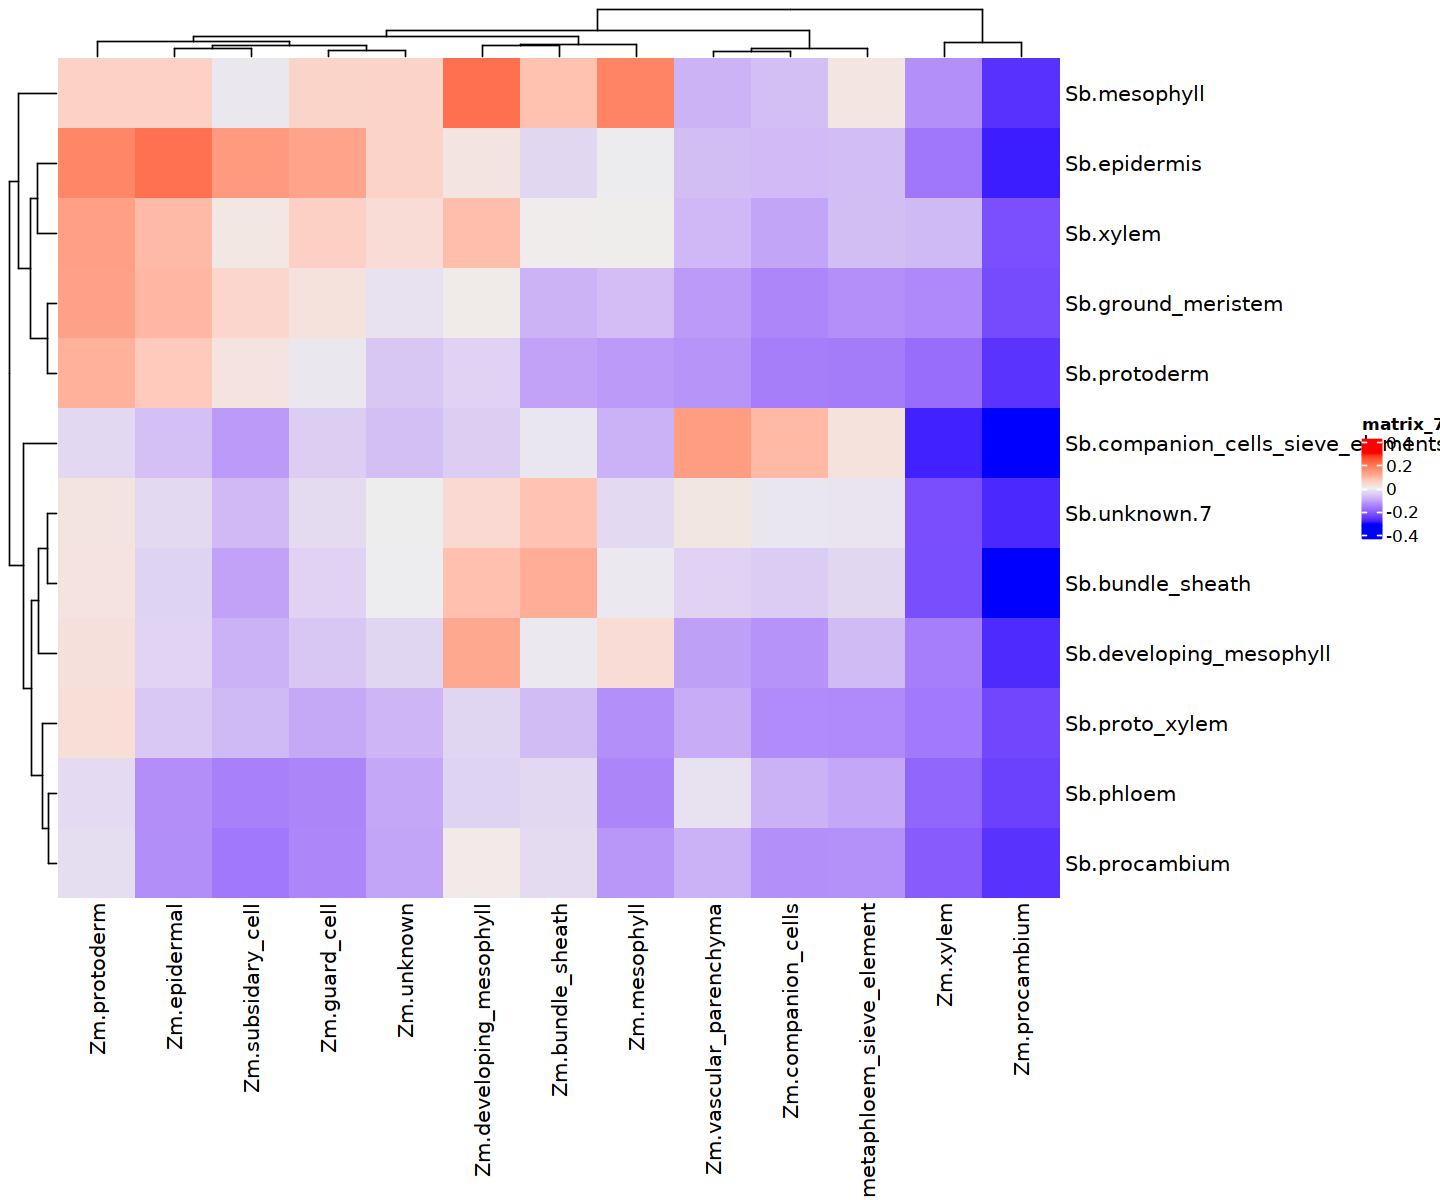

In [37]:
options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((sb.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
Heatmap(var.orthos.final)

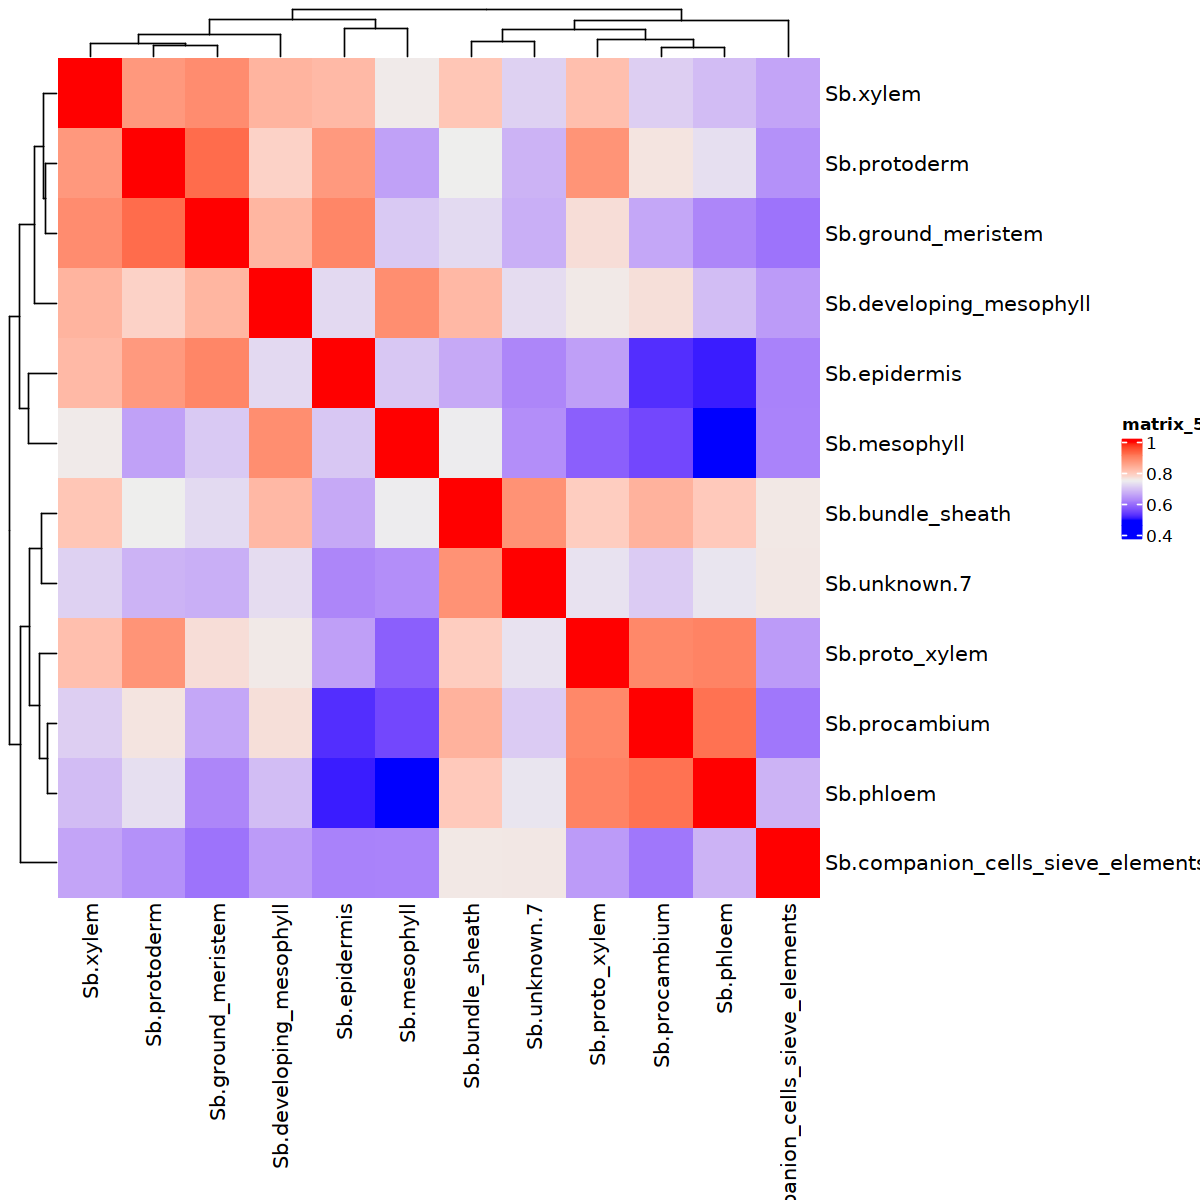

In [32]:
var.orthos.final <- cor((sb.cell_types.var_orthos.final), (sb.cell_types.var_orthos.final))
Heatmap(var.orthos.final)

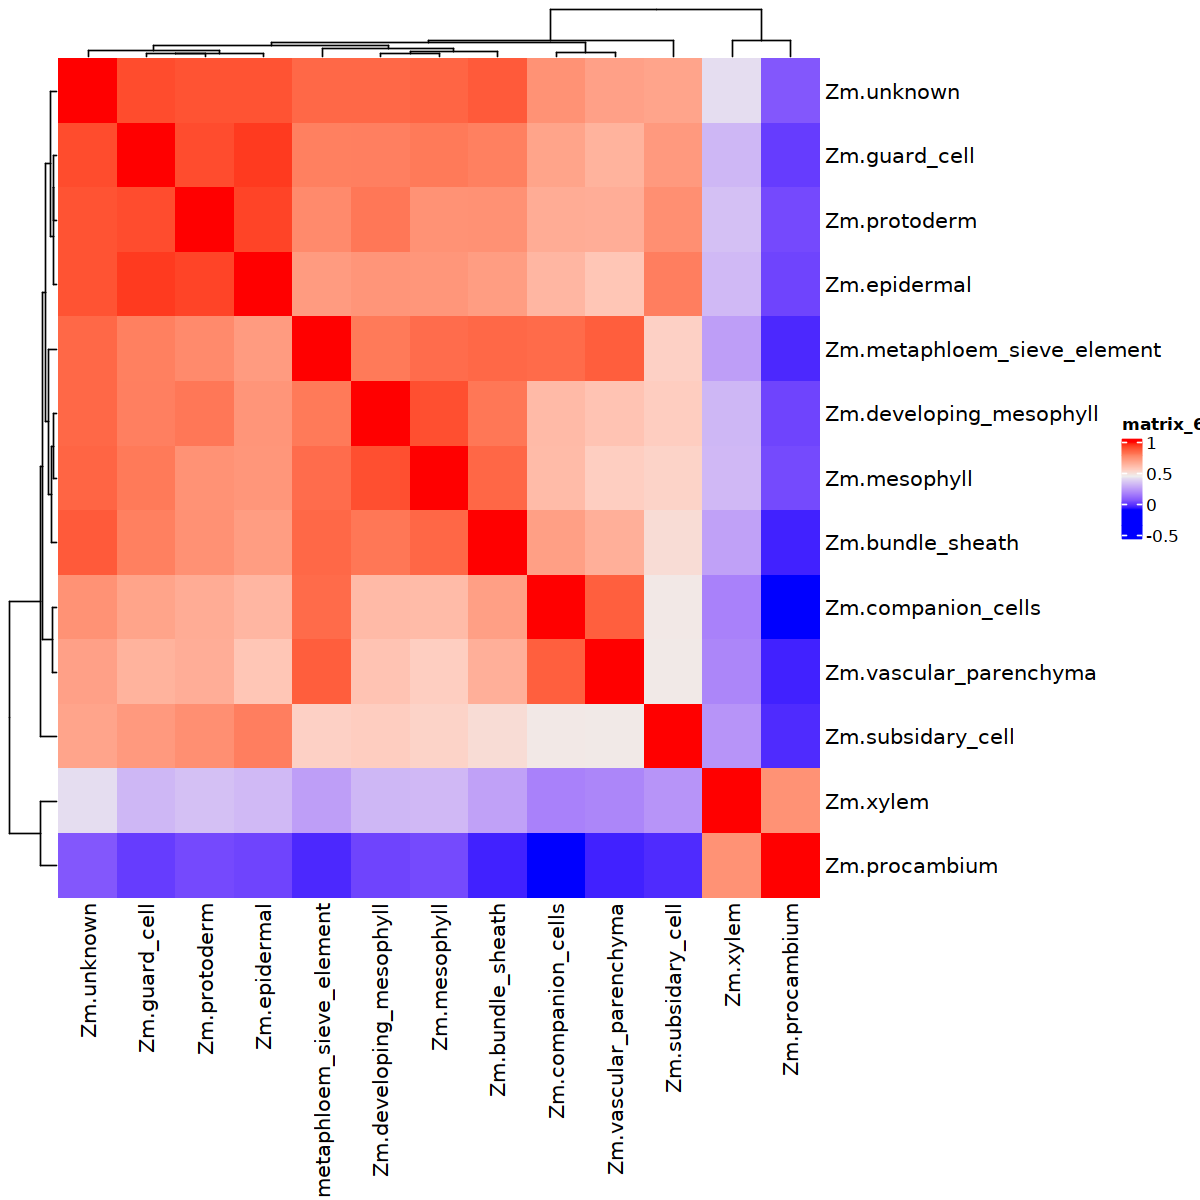

In [33]:
var.orthos.final <- cor((zm.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
Heatmap(var.orthos.final)

In [34]:
colnames(zm_meta_data)

[1] "cellID"                    "total"                    
 [3] "tss"                       "acrs"                     
 [5] "ptmt"                      "nSites"                   
 [7] "log10nSites"               "sampleID"                 
 [9] "umap1"                     "umap2"                    
[11] "doubletscore"              "d.type"                   
[13] "LouvainClusters"           "Louvain_cluster_safe"     
[15] "cell_annotation_glmnet"    "cell_annotation_knn"      
[17] "cell_annotation_enrich"    "cell_annotation_smooth"   
[19] "cluster_annotation_glmnet" "cluster_annotation_knn"   
[21] "cluster_annotation_smooth" "cluster_annotation_enrich"
[23] "LouvainClusters_t"         "V1_annotation"            
[25] "V2_annotation"             "V3_final_annnotation"     
[27] "total_cell_count"          "V3_annotation_n"

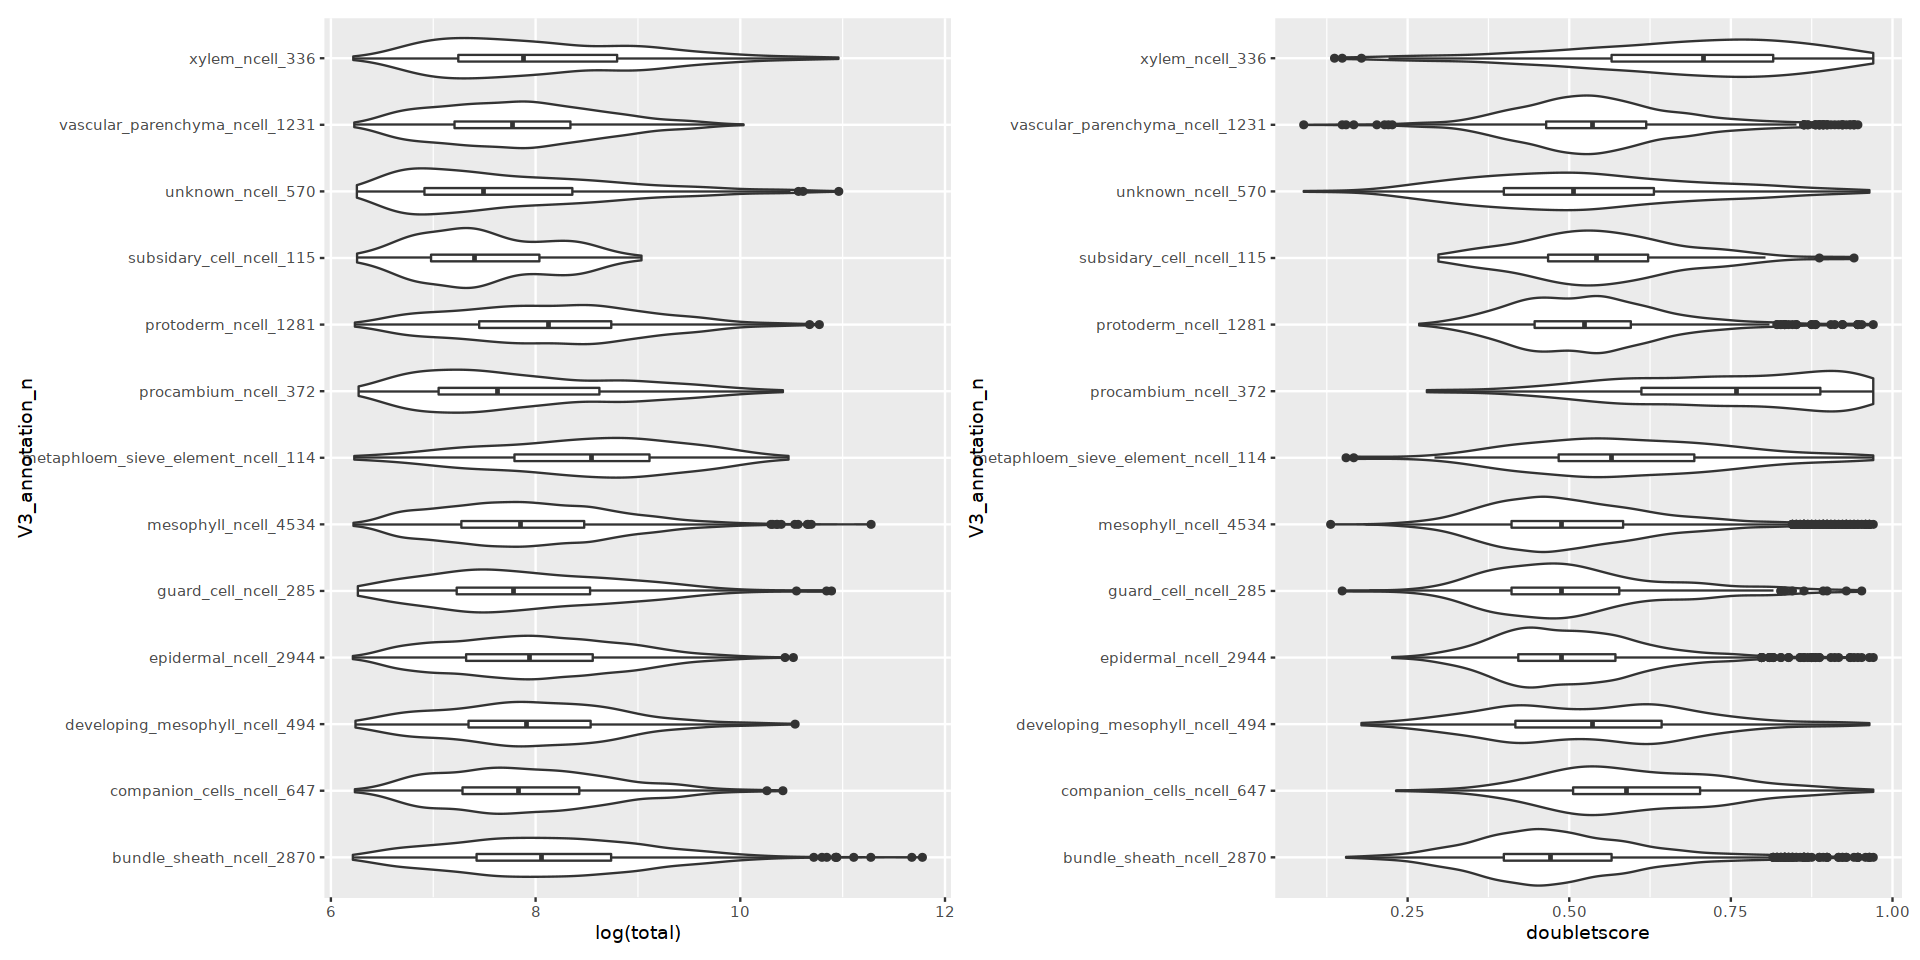

In [36]:
library(patchwork)
options(repr.plot.width=16, repr.plot.height=8)
total_tn5 <- ggplot(zm_meta_data, aes(x = V3_annotation_n, y = log(total))) + 
    geom_violin() + 
    geom_boxplot(width = .1) +
      coord_flip()


doublet_score <- ggplot(zm_meta_data, aes(x = V3_annotation_n, y = doubletscore)) + 
    geom_violin() + 
    geom_boxplot(width = .1) +
      coord_flip()


total_tn5 + doublet_score


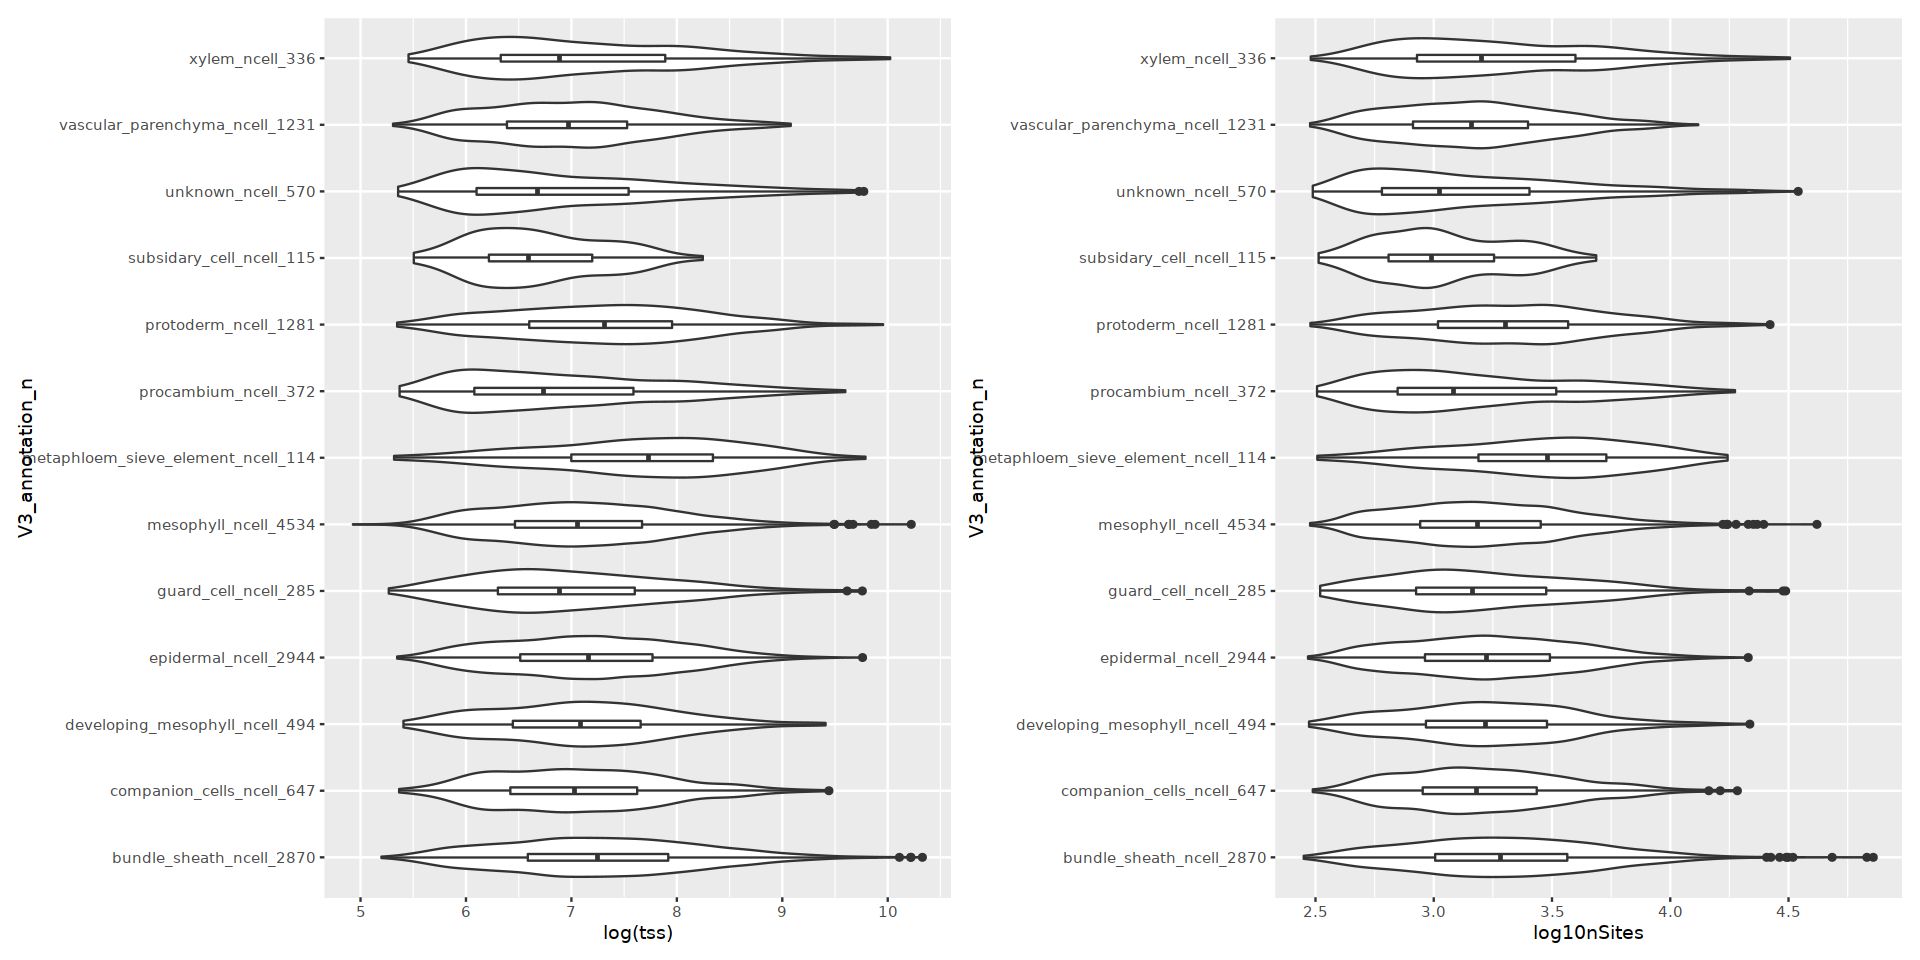

In [192]:
library(patchwork)
options(repr.plot.width=16, repr.plot.height=8)
total_tn5 <- ggplot(zm_meta_data, aes(x = V3_annotation_n, y = log(tss))) + 
    geom_violin() + 
    geom_boxplot(width = .1) +
      coord_flip()


doublet_score <- ggplot(zm_meta_data, aes(x = V3_annotation_n, y = log10nSites)) + 
    geom_violin() + 
    geom_boxplot(width = .1) +
      coord_flip()


total_tn5 + doublet_score


In [1]:
marker_correlation <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
   
    
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    
    
        
    merged_meta_cpm_information <- left_join(meta_data, loaded_sparse_matric, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
        group_by(!!sym(cluster_name), geneID)  %>%
        summarise(counts = sum(accessability, na.rm = TRUE))

    ### Alt CPM Calc
    merged_meta_cpm_information_copied <- merged_meta_cpm_information
    catch <- merged_meta_cpm_information_copied  %>%
        group_by(!!sym(cluster_name)) %>%
        group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
        unlist()

    
    caught_values <- as_tibble(catch)
    sb_merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
        rename(grouped_CPM = value)
    
    
    #Apply quantile normalization
    merged_meta.quant_norm <- merged_meta_cpm_information_copied  %>% 
        group_by(sb_v4_annot)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

    quantile_normalized <- as_tibble(merged_meta.quant_norm)  %>% 
        rename("quant_norm_cpm" = value)

    #Combine and re_name
    merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, quantile_normalized)  %>% 
        ungroup()  %>% 
        select(!!sym(cluster_name), geneID, quant_norm_cpm)  %>% 
        pivot_wider(names_from = !!sym(cluster_name), values_from = quant_norm_cpm, values_fill = 0)


    
    meta_obj[["corr_matrix"]] <- merged_meta_cpm_information_copied
    
    return(meta_obj)
}

ERROR: Error in parse(text = x, srcfile = src): <text>:1:23: unexpected assignment
1: marker_correlation <- <-
                          ^


In [ ]:

raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(!!sym(cluster_name), geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
merged_meta_cpm_information_copied <- merged_meta_cpm_information
catch <- merged_meta_cpm_information_copied  %>%
    group_by(!!sym(cluster_name)) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



caught_values <- as_tibble(catch)
see <- ungroup(merged_meta_cpm_information_copied)
merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    group_by(!!sym(cluster_name)) %>%  
    mutate(log_cpm  = log(grouped_CPM))


#Apply quantile normalization
merged_meta.quant_norm <- merged_meta_cpm_information_copied  %>% 
        group_by(!!sym(cluster_name))  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

zm.quantile_normalized <- as_tibble(merged_meta.quant_norm)  %>% 
    rename("quant_norm_cpm" = value)


merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, zm.quantile_normalized)

cell_type_accessability <- merged_meta_cpm_information_copied  %>% 
    ungroup()  %>% 
    select(!!sym(cluster_name), geneID, quant_norm_cpm)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cpm, values_fill = 0)
    